In [2]:
import numpy as np
import os
import PIL
import matplotlib.pyplot as plt
import sys
import torch
sys.path.append("./Utils")
from utils import get_loaders, load_checkpoint
sys.path.append('./Models')
from U_net import UNET
import torchvision

In [3]:
path_train = "../Data/dataset_DRIVE/training/images/"
training_images = os.listdir(path_train)

In [4]:
train_images = {}
for i in sorted(training_images):
    number = i[0:2]
    img = np.array(PIL.Image.open(f'{path_train}{i}').convert("RGB"))
    train_images[str(number)] =  img

In [5]:
train_images['21'].shape

(584, 565, 3)

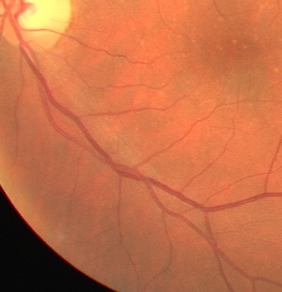

In [6]:
from torchvision.transforms import RandomCrop
from torchvision.transforms import Compose, ToTensor
import torchvision.transforms.functional as TF
i, j, h, w = RandomCrop.get_params(
            PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB'),
             output_size=(292, 282))
TF.crop(PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB'), i, j, h, w)

Text(0.5, 1.0, '21')

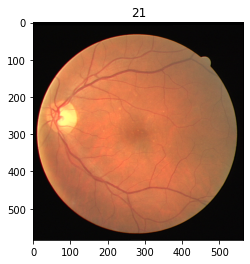

In [7]:
plt.imshow(train_images['21'])
plt.title('21')

(584, 565, 3)


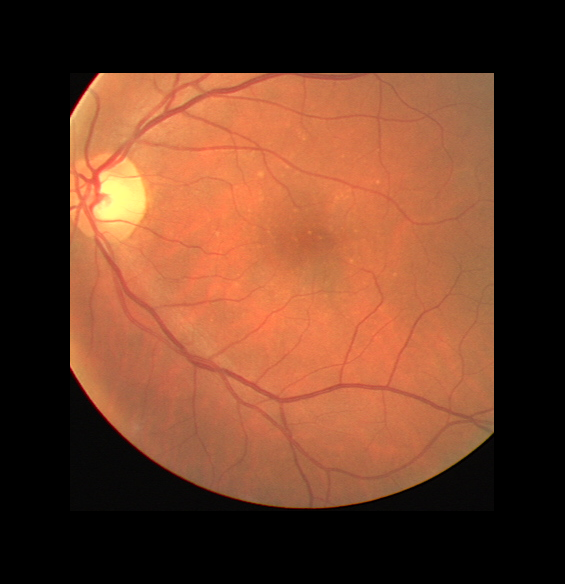

In [8]:
size = (438, 424)
i, j, h, w = RandomCrop.get_params(
            PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB'),
             output_size=size)
TF.crop(PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB'), i, j, h, w)
up_down_pad = 584 - size[0]
left_right_pad = 565 - size[1]
top = up_down_pad//2
bottom = top + up_down_pad % 2
left = left_right_pad//2
right = left + left_right_pad % 2
cropped = TF.crop(PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB'), i, j, h, w)
print(np.asarray(TF.pad(cropped, (left, top, right, bottom))).shape)
TF.pad(cropped, (left, top, right, bottom))

In [9]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return torch.clip(tensor + torch.randn(tensor.size()) * self.std + self.mean, 0, 1)
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

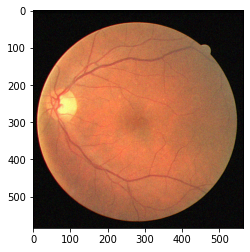

In [10]:
transform=Compose([
    ToTensor(),
    AddGaussianNoise(0, 0.05)
])

examp = transform(train_images['21'])
plt.imshow(examp.permute(1, 2, 0) , alpha=1)

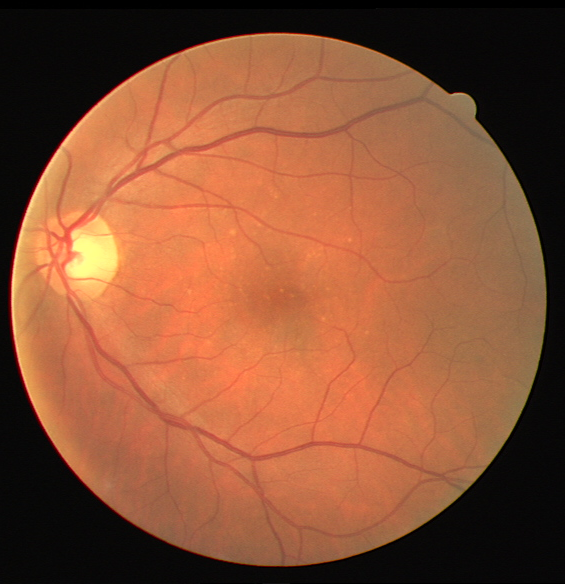

In [11]:
PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB')

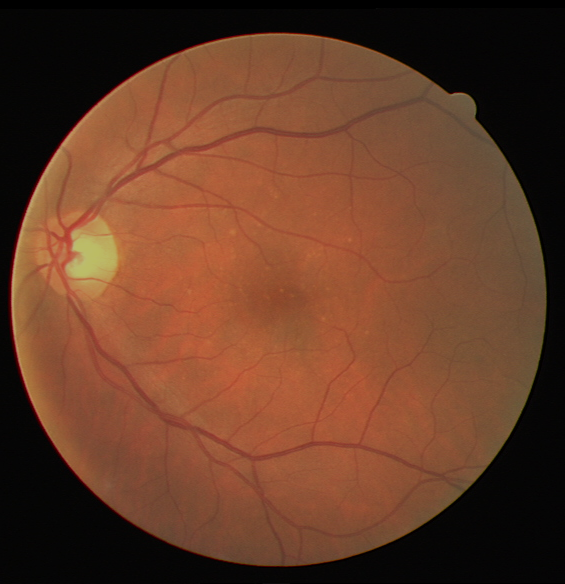

In [12]:
TF.adjust_brightness(PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB'), np.random.uniform(0.5, 1.5))

In [13]:
#Procesado de los labels

In [14]:
path_labels = "../Data/dataset_DRIVE/training/1st_manual/"
training_labels = os.listdir(path_labels)
labels = {}
for image in training_labels:
    img = np.array(PIL.Image.open(f'{path_labels}{image}').convert("L"), dtype=np.float32)
    labels[image[0:2]] = img

Text(0.5, 1.0, '21')

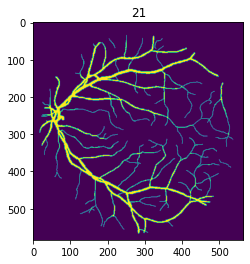

In [15]:
plt.imshow(labels['21'])
plt.title('21')

In [16]:
zeros = []
ones = []
for i in labels.keys():
    aux = labels[i]
    zeros.append(np.sum(aux==0).sum())
    ones.append(np.sum(aux==255).sum())

print(f"Avg_ratio: {np.mean(zeros)/np.mean(ones)}")

Avg_ratio: 10.646914517168044


Text(0.5, 1.0, '21')

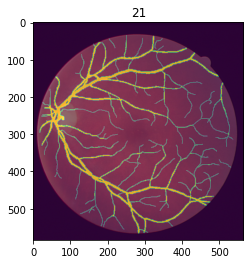

In [17]:
plt.imshow(labels['21'], alpha=1)
plt.imshow(train_images['21'], alpha=0.4)
plt.title('21')

In [60]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Training Loader params

kwargs = {'train_dir': '../Data/dataset_DRIVE/training/images',
          'train_maskdir': '../Data/dataset_DRIVE/training/1st_manual',
          'val_dir': '../Data/dataset_DRIVE/validation/images',
          'val_maskdir': '../Data/dataset_DRIVE/validation/1st_manual',
          'batch_size': 3,
          'rotation': [-180, 180],
          'hflip_prob': 0.5,
          'brightness': [0.8, 1.2],
          'contrast': [0.8, 1.2],
          'gamma': [0.9, 1.1],
          'affine_translate': [0.05, 0.1],  # Horiz and vert translation
          'affine_scale': [1, 2],
          'affine_shears': [0, 10],
          'noise': (0, 0.05), # (Mean,std)
          'num_workers': 0,
          'pin_memory': True}

In [61]:
train_loader, val_loader = get_loaders(**kwargs)

Feature batch shape: torch.Size([3, 3, 584, 565])
Labels batch shape: torch.Size([3, 584, 565])
The Train image numbers present in the batch are: ('27', '30', '31')


Text(0.5, 1.0, '27')

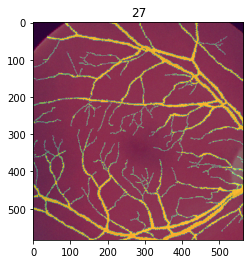

In [72]:
train_features, train_labels, numbers = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(f"The Train image numbers present in the batch are: {numbers}")
img = train_features[0].squeeze()
label = train_labels[0]
number = numbers[0]
plt.imshow(label, alpha=1)
plt.imshow(img.permute(1, 2, 0) , alpha=0.4)
plt.title(number)

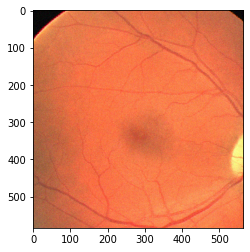

In [73]:
plt.imshow(img.permute(1, 2, 0) , alpha=1)

# Model 

In [14]:
checks1 = "./Checkpoints/2022_01_30_1/training_logs.pt"
checks2 = "./Checkpoints/2022_01_30_2/training_logs.pt"

weights1 = "./Checkpoints/2022_01_30_1/my_check.pth.tar"
weights2 = "./Checkpoints/2022_01_30_2/my_check.pth.tar"
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
load_checkpoint(torch.load(weights2, map_location=torch.device(DEVICE)),
    model)

 => Loading checkpoint 


In [6]:
a = torch.load(checks1)
b = torch.load(checks2)

In [30]:
a['best_dice']
b['best_dice']

0.7990298239364273

In [7]:
a['best_auc']

0.9840781571429302

In [ ]:
#Aquí se pintarían las gráficas

# Submission Grand Challenge

In [15]:
TEST_IMG_DIR = "../Data/dataset_DRIVE/test"

In [16]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
from utils import make_grid

In [10]:
test = ImageFolder(root=TEST_IMG_DIR, transform=transforms.ToTensor())

In [17]:
BATCH_SIZE = 4
test_loader = DataLoader(test, batch_size=BATCH_SIZE)

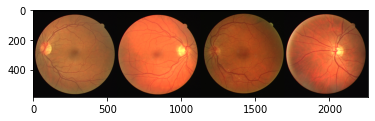

In [18]:
#First 4 test images
grid = make_grid(next(iter(test_loader))[0], nrow=4, padding=0, scale_each=True)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [19]:
# Predictions
folder = "../Data/dataset_DRIVE/submit/2022_01_30_2"
model.eval()
number = list(range(1,5,1))
for x in test_loader:
    x = x[0].to(device=DEVICE)
    with torch.no_grad():
        preds = torch.sigmoid(model(x))
        preds = (preds > 0.5).float()
        for a,b in zip(preds,number):
            torchvision.utils.save_image(
            a, f"{folder}/{b}.png")
    number = [x + BATCH_SIZE for x in number]
